<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/CIFAR_100_TrainValid_Gamma_Correction_AugMix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gamma Correction as Augmentaion

In [ ]:
############## Start Gamma Correction ############
import torch
import torchvision.transforms.functional as TF
import numbers

class GammaCorrectionTransform:
    """Apply Gamma Correction to the image"""
    def __init__(self, gamma=0.5):
        self.gamma = self._check_input(gamma, 'gammacorrection')   
        
    def _check_input(self, value, name, center=1, bound=(0, float('inf')), clip_first_on_zero=True):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError("If {} is a single number, it must be non negative.".format(name))
            value = [center - float(value), center + float(value)]
            if clip_first_on_zero:
                value[0] = max(value[0], 0.0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError("{} values should be between {}".format(name, bound))
        else:
            raise TypeError("{} should be a single number or a list/tuple with length 2.".format(name))

        # if value is 0 or (1., 1.) for gamma correction do nothing
        if value[0] == value[1] == center:
            value = None
        return value

    def __call__(self, img):
        """
        Args:
            img (PIL Image or Tensor): Input image.

        Returns:
            PIL Image or Tensor: gamma corrected image.
        """
        gamma_factor = None if self.gamma is None else float(torch.empty(1).uniform_(self.gamma[0], self.gamma[1]))
        if gamma_factor is not None:
            img = TF.adjust_gamma(img, gamma_factor, gain=1)
        return img
############## End Gamma Correction ############

In [ ]:
### Start AugMix ###
# Copyright 2019 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Base augmentations operators."""

import numpy as np
from PIL import Image, ImageOps, ImageEnhance

# ImageNet code should change this value
IMAGE_SIZE = 32


def int_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .

  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.

  Returns:
    An int that results from scaling `maxval` according to `level`.
  """
  return int(level * maxval / 10)


def float_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval.

  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.

  Returns:
    A float that results from scaling `maxval` according to `level`.
  """
  return float(level) * maxval / 10.


def sample_level(n):
  return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
  return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
  return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
  level = int_parameter(sample_level(level), 4)
  return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
  degrees = int_parameter(sample_level(level), 30)
  if np.random.uniform() > 0.5:
    degrees = -degrees
  return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
  level = int_parameter(sample_level(level), 256)
  return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

def aug(image, preprocess):
  """Perform AugMix augmentations and compute mixture.

  Args:
    image: PIL.Image input image
    preprocess: Preprocessing function which should return a torch tensor.

  Returns:
    mixed: Augmented and mixed image.
  """
  aug_list = augmentations
  if args.all_ops == 'True':
    aug_list = augmentations_all

  ws = np.float32(np.random.dirichlet([1] * args.mixture_width))
  m = np.float32(np.random.beta(1, 1))

  mix = torch.zeros_like(preprocess(image))
  for i in range(args.mixture_width):
    image_aug = image.copy()
    depth = args.mixture_depth if args.mixture_depth > 0 else np.random.randint(
        1, 4)
    for _ in range(depth):
      op = np.random.choice(aug_list)
      image_aug = op(image_aug, args.aug_severity)
    # Preprocessing commutes since all coefficients are convex
    mix += ws[i] * preprocess(image_aug)

  mixed = (1 - m) * preprocess(image) + m * mix
  return mixed


class AugMixDataset(torch.utils.data.Dataset):
  """Dataset wrapper to perform AugMix augmentation."""

  def __init__(self, dataset, preprocess, no_jsd='True'):
    self.dataset = dataset
    self.preprocess = preprocess
    self.no_jsd = no_jsd

  def __getitem__(self, i):
    x, y = self.dataset[i]
    if self.no_jsd == 'True':
      return aug(x, self.preprocess), y
    else:
      im_tuple = (self.preprocess(x), aug(x, self.preprocess),
                  aug(x, self.preprocess))
      return im_tuple, y

  def __len__(self):
    return len(self.dataset)
### End AugMix ###

CIFAR-100 contains 500000 samples in training set. We split to 40000/10000 for train and validation.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import os
import argparse
import copy
import random
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def seed_everything(seed=12):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
parser = argparse.ArgumentParser(description='CIFAR-10H Training')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
parser.add_argument('--batch_size', default=1024, type=int, help='batch size')
parser.add_argument('--test_batch_size', default=2048, type=int, help='batch size')
parser.add_argument('--num_epoch', default=100, type=int, help='epoch number')
parser.add_argument('--num_classes', type=int, default=100, help='number classes')

# AugMix #
parser.add_argument('--augmix', default='True', type=str, help='Turn off JSD consistency loss.')
parser.add_argument('--no-jsd', default='True', type=str, help='Turn off JSD consistency loss.')
parser.add_argument('--all-ops', default='True', type=str, help='Turn on all operations (+brightness,contrast,color,sharpness).')
parser.add_argument('--mixture-width', default=3, type=int, help='Number of augmentation chains to mix per augmented example')
parser.add_argument('--mixture-depth', default=-1, type=int, help='Depth of augmentation chains. -1 denotes stochastic depth in [1, 3]')
parser.add_argument('--aug-severity', default=3, type=int, help='Severity of base augmentation operators')
############

args = parser.parse_args(args=[])

def train(model, trainloader, criterion, optimizer):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total


CIFAR-100 TrainValid Dataloader

In [ ]:
from PIL import Image
import numpy as np
import torchvision
import matplotlib.pyplot as plt

class CIFAR100_TrainValid(torchvision.datasets.CIFAR100):

    def __init__(self, root,  rand_number=0, istrain=True, train=True, transform=None, target_transform=None,
                 download=False):
        super(CIFAR100_TrainValid, self).__init__(root, train, transform, target_transform, download) 
        self.transform = transform
        self.target_transform = target_transform
        if istrain:
            self.data, self.targets = self.data[:40000], self.targets[:40000]
            
        else:
            self.data, self.targets = self.data[40000:], self.targets[40000:]

        hist = np.histogram(self.targets, bins=100, range=(0,100))[0]
        print(hist)
        #plt.hist(self.targets, bins='auto')
        plt.bar(np.arange(len(hist)),hist)
        plt.show()
    def __getitem__(self, index: int):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

Files already downloaded and verified
[397 387 402 398 389 391 404 391 423 398 374 398 398 393 415 393 414 408
 413 416 398 409 412 396 395 386 396 398 382 390 391 413 417 412 409 401
 401 390 408 391 409 396 410 413 396 394 394 388 399 403 388 395 383 389
 415 396 398 396 413 414 416 414 399 402 402 408 413 411 406 410 405 417
 412 398 395 394 395 395 408 394 387 408 395 401 391 397 389 405 393 405
 392 386 414 405 384 392 386 386 398 406]


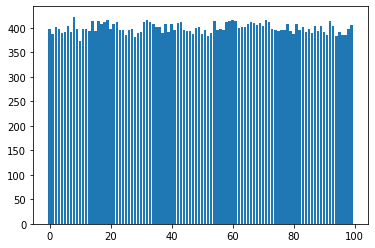

Files already downloaded and verified
[397 387 402 398 389 391 404 391 423 398 374 398 398 393 415 393 414 408
 413 416 398 409 412 396 395 386 396 398 382 390 391 413 417 412 409 401
 401 390 408 391 409 396 410 413 396 394 394 388 399 403 388 395 383 389
 415 396 398 396 413 414 416 414 399 402 402 408 413 411 406 410 405 417
 412 398 395 394 395 395 408 394 387 408 395 401 391 397 389 405 393 405
 392 386 414 405 384 392 386 386 398 406]


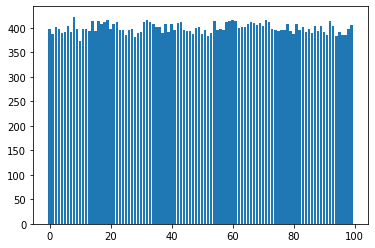

Files already downloaded and verified
[103 113  98 102 111 109  96 109  77 102 126 102 102 107  85 107  86  92
  87  84 102  91  88 104 105 114 104 102 118 110 109  87  83  88  91  99
  99 110  92 109  91 104  90  87 104 106 106 112 101  97 112 105 117 111
  85 104 102 104  87  86  84  86 101  98  98  92  87  89  94  90  95  83
  88 102 105 106 105 105  92 106 113  92 105  99 109 103 111  95 107  95
 108 114  86  95 116 108 114 114 102  94]


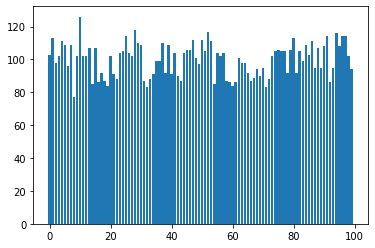

train samples: 40000 valid samples: 10000


In [ ]:
seed_everything()
mean_cifar100, std_cifar100 = (0.5071, 0.4866, 0.4409), (0.2009, 0.1984, 0.2023)

transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
            transforms.RandomApply(transforms=[GammaCorrectionTransform(gamma=0.1)], p=0.5),
            transforms.RandomHorizontalFlip(), transforms.ToTensor(),
            transforms.Normalize(mean_cifar100, std_cifar100), ])
train_dataset = CIFAR100_TrainValid(root='./data', istrain=True, download=True, transform=transform_train)
    
transform_test = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(mean_cifar100, std_cifar100),])

### Apply AugMix ###
if args.augmix == 'True':
    transform_train_augmix = transforms.Compose([transforms.RandomCrop(32, padding=4),
            transforms.RandomApply(transforms=[GammaCorrectionTransform(gamma=0.1)], p=0.5),
            transforms.RandomHorizontalFlip(),])
    train_dataset = CIFAR100_TrainValid(root='./data', istrain=True, download=True, transform=transform_train_augmix)
    preprocess = transform_test
    train_dataset = AugMixDataset(train_dataset, preprocess, args.no_jsd) # Turn off JSD consistency loss
#######################

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
test_dataset = CIFAR100_TrainValid(root='./data', istrain=False, download=True, transform=transform_train)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=2)
print('train samples:',len(train_dataset), 'valid samples:',len(test_dataset))

In [ ]:
model = models.resnet34(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, args.num_classes)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, nesterov=False, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

best_epoch, best_acc = 0.0, 0
for epoch in range(args.num_epoch):
    train(model, train_loader, criterion, optimizer)
    accuracy = test(model, test_loader)
    if accuracy > best_acc:
        patience = 0
        best_acc = accuracy
        best_epoch = epoch
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), 'best_model_cifar10h.pth.tar')
    print('epoch: {}  acc: {:.4f}  best epoch: {}  best acc: {:.4f}'.format(
            epoch, accuracy, best_epoch, best_acc, optimizer.param_groups[0]['lr']))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch: 0  acc: 0.0143  best epoch: 0  best acc: 0.0143
epoch: 1  acc: 0.0134  best epoch: 0  best acc: 0.0143
epoch: 2  acc: 0.0372  best epoch: 2  best acc: 0.0372
epoch: 3  acc: 0.0636  best epoch: 3  best acc: 0.0636
epoch: 4  acc: 0.0772  best epoch: 4  best acc: 0.0772
epoch: 5  acc: 0.0904  best epoch: 5  best acc: 0.0904
epoch: 6  acc: 0.0910  best epoch: 6  best acc: 0.0910
epoch: 7  acc: 0.1091  best epoch: 7  best acc: 0.1091
epoch: 8  acc: 0.1068  best epoch: 7  best acc: 0.1091
epoch: 9  acc: 0.1215  best epoch: 9  best acc: 0.1215
epoch: 10  acc: 0.1512  best epoch: 10  best acc: 0.1512
epoch: 11  acc: 0.1655  best epoch: 11  best acc: 0.1655
epoch: 12  acc: 0.1747  best epoch: 12  best acc: 0.1747
epoch: 13  acc: 0.1698  best epoch: 12  best acc: 0.1747
epoch: 14  acc: 0.1851  best epoch: 14  best acc: 0.1851
epoch: 15  acc: 0.1918  best epoch: 15  best acc: 0.1918
epoch: 16  acc: 0.1942  best epoch: 16  best acc: 0.1942
epoch: 17  acc: 0.1760  best epoch: 16  best acc: 0